In [16]:
# Import packages 
import pandas as pd
import numpy as np
from os.path import join
import joblib
import matplotlib.pyplot as plt
import pickle

# We add the github package to our system path so we can import python scripts for that repo. 
import sys
sys.path.append('/home/samuel.varga/python_packages/verification_diagrams')


from verification_diagrams._plot import plot_verification
import itertools
from verification_diagrams import sklearn_curve_bootstrap, VerificationDiagram
from verification_diagrams import brier_skill_score
from verification_diagrams._curve_utils import sklearn_curve_bootstrap
from verification_diagrams._metrics import reliability_uncertainty, brier_skill_score, bss_resolution, max_csi, _binary_uninterpolated_average_precision, bss_reliability 
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss
from sklearn.metrics._base import _average_binary_score 
from functools import partial

In [17]:
sys.path.append('/home/samuel.varga/projects/deep_learning/')
from deep_learning.training_utils import load_rotation
%matplotlib inline

In [21]:
target_column='any_severe__36km'
target_columns = ['any_severe__36km','hail_severe__36km','wind_severe__36km','tornado_severe__36km']
X_test, y_test = load_rotation(join('/work/samuel.varga/data/2to6_hr_severe_wx/DEEP_LEARNING/',f'wofs_dl_severe__2to6hr__testing_data.nc'), None, target_columns)
X_val, y_val = load_rotation(join('/work/samuel.varga/data/2to6_hr_severe_wx/DEEP_LEARNING/',f'wofs_dl_severe__2to6hr__rot_{0}__validation_data.nc'), 0, target_column)

y_test = y_test[target_column]
print(np.shape(y_test))
print(np.shape(y_test.flatten()))

(3410, 16, 16)
(872960,)


In [22]:
out_path = '/work/samuel.varga/projects/2to6_hr_severe_wx/DEEP_LEARNING/results/'
result_path = f'any_severe__36km_Rot_0_16_16_lrate_0.0001_spatial_dropout_0.25_i_3_filters_[96, 192, 384, 768]_size_[4, 3, 2, 2]_pool_[2, 2, 2, 2]_loss_binary_crossentropy_results.pkl'
results = pd.read_pickle(join(out_path, result_path))

In [23]:
results.keys()

dict_keys(['args', 'predict_val_eval', 'predict_val', 'predict_test', 'predict_test_eval', 'predict_train_eval', 'history', 'fname_base'])

# Training Metrics

In [60]:
results['history'].keys()
print('Valid Metrics:')
print(list(results["history"].keys()))

Valid Metrics:
['loss', 'sparse_categorical_accuracy', 'Brier score', 'auc', 'prc', 'FN', 'FP', 'MAE', 'TN', 'TP', 'bss', 'val_loss', 'val_sparse_categorical_accuracy', 'val_Brier score', 'val_auc', 'val_prc', 'val_FN', 'val_FP', 'val_MAE', 'val_TN', 'val_TP', 'val_bss']


# Performance Diagram

In [35]:
import xarray as xr
val_meta = xr.open_dataset(join('/work/samuel.varga/data/2to6_hr_severe_wx/DEEP_LEARNING','wofs_dl_severe__2to6hr__rot_0__validation_meta.nc') , engine='netcdf4')
test_meta = xr.open_dataset(join('/work/samuel.varga/data/2to6_hr_severe_wx/DEEP_LEARNING','wofs_dl_severe__2to6hr__testing_meta.nc') , engine='netcdf4')

In [37]:
test_groups = np.repeat(test_meta['init_time'].values, 16*16) 
val_groups = np.repeat(val_meta['init_time'].values, 16*16) 
def init_time_to_groups(init_times):
    '''Converts init times to four groups separated by 4 hours'''
    init_times=init_times.astype(int)/100 #Divide by 100 to remove trailing zeros
    init_times = init_times % 4
    return init_times
test_groups = init_time_to_groups(test_groups)
val_groups = init_time_to_groups(val_groups)
print(len(test_groups))
print(len(val_groups))

872960
391680


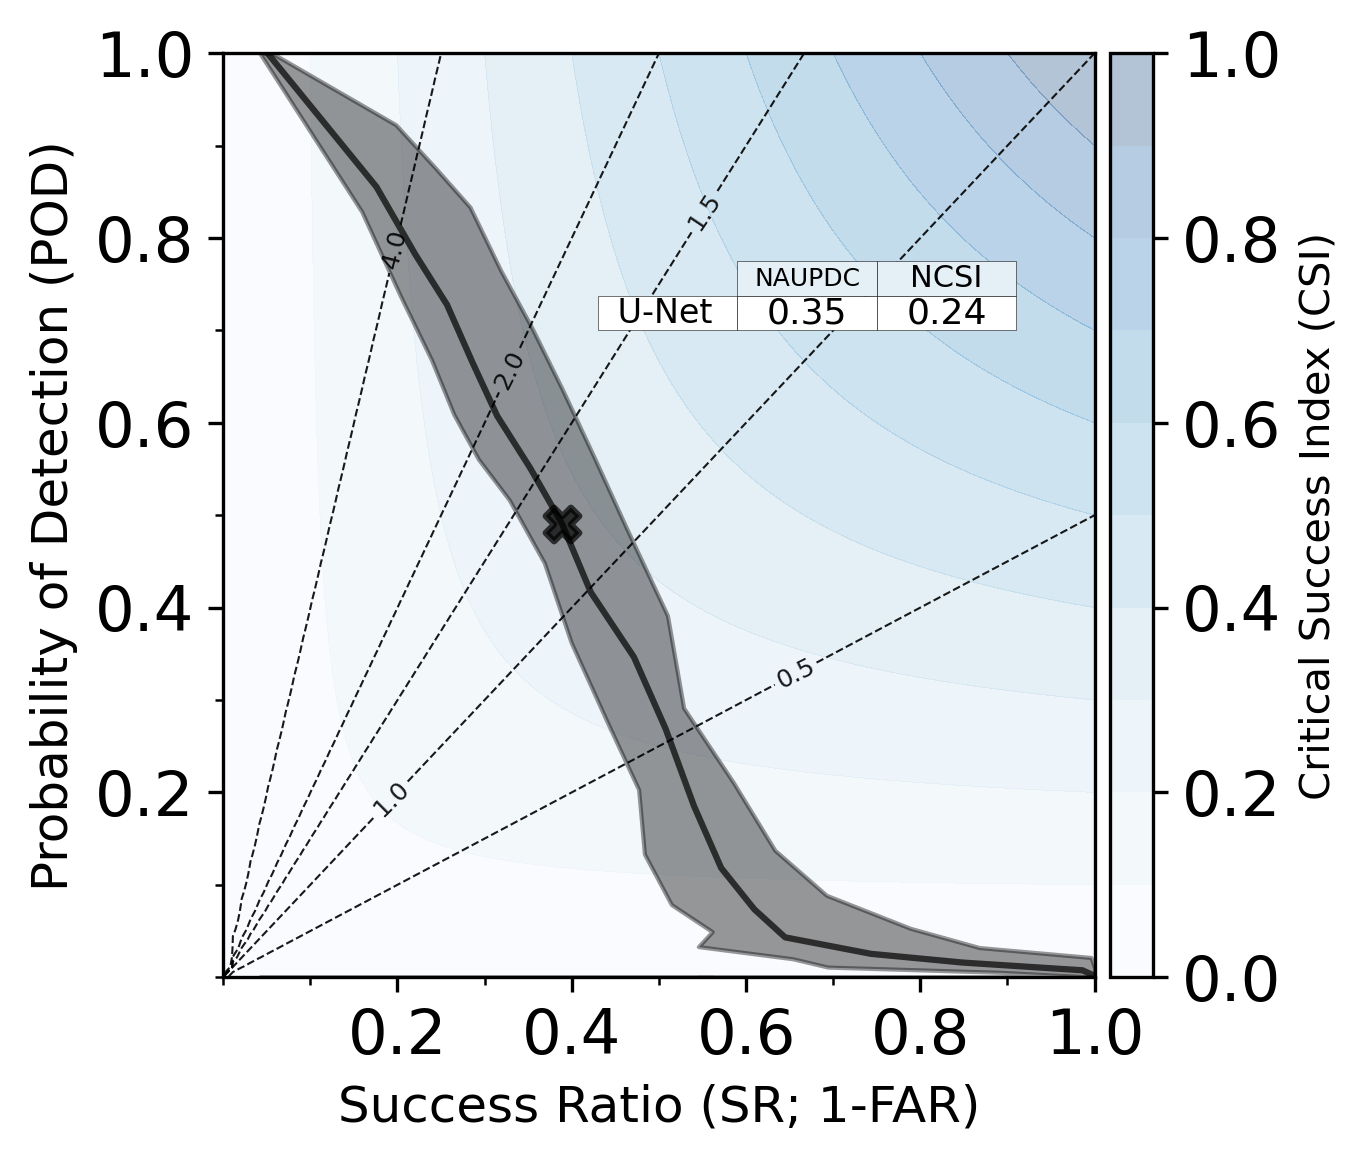

In [38]:
name = 'U-Net'
_xx={}
_yy={}
_scores={}
scores={'U-Net':{}}
xx, yy, score = sklearn_curve_bootstrap(y_val.flatten(), results['predict_val'].flatten(), metric='performance', 
                                         n_boot=15, groups=val_groups, 
                            random_seed=42)
_scores[name]=score
for metric in score:
    scores['U-Net'][metric]=np.nanmean(score[metric])
_xx[name]=xx
_yy[name]=yy
vd = VerificationDiagram()

ax = vd.plot('performance', _xx, _yy, scores=_scores,  add_dots=False, 
             add_max_marker=True, table_fontsize=8,  table_alpha=1, line_colors=['k'],
            plot_kwargs={'line_colors':'k'},
             #table_bbox=[0.75, 0.65, 0.25, 0.4]
            )
plt.show()

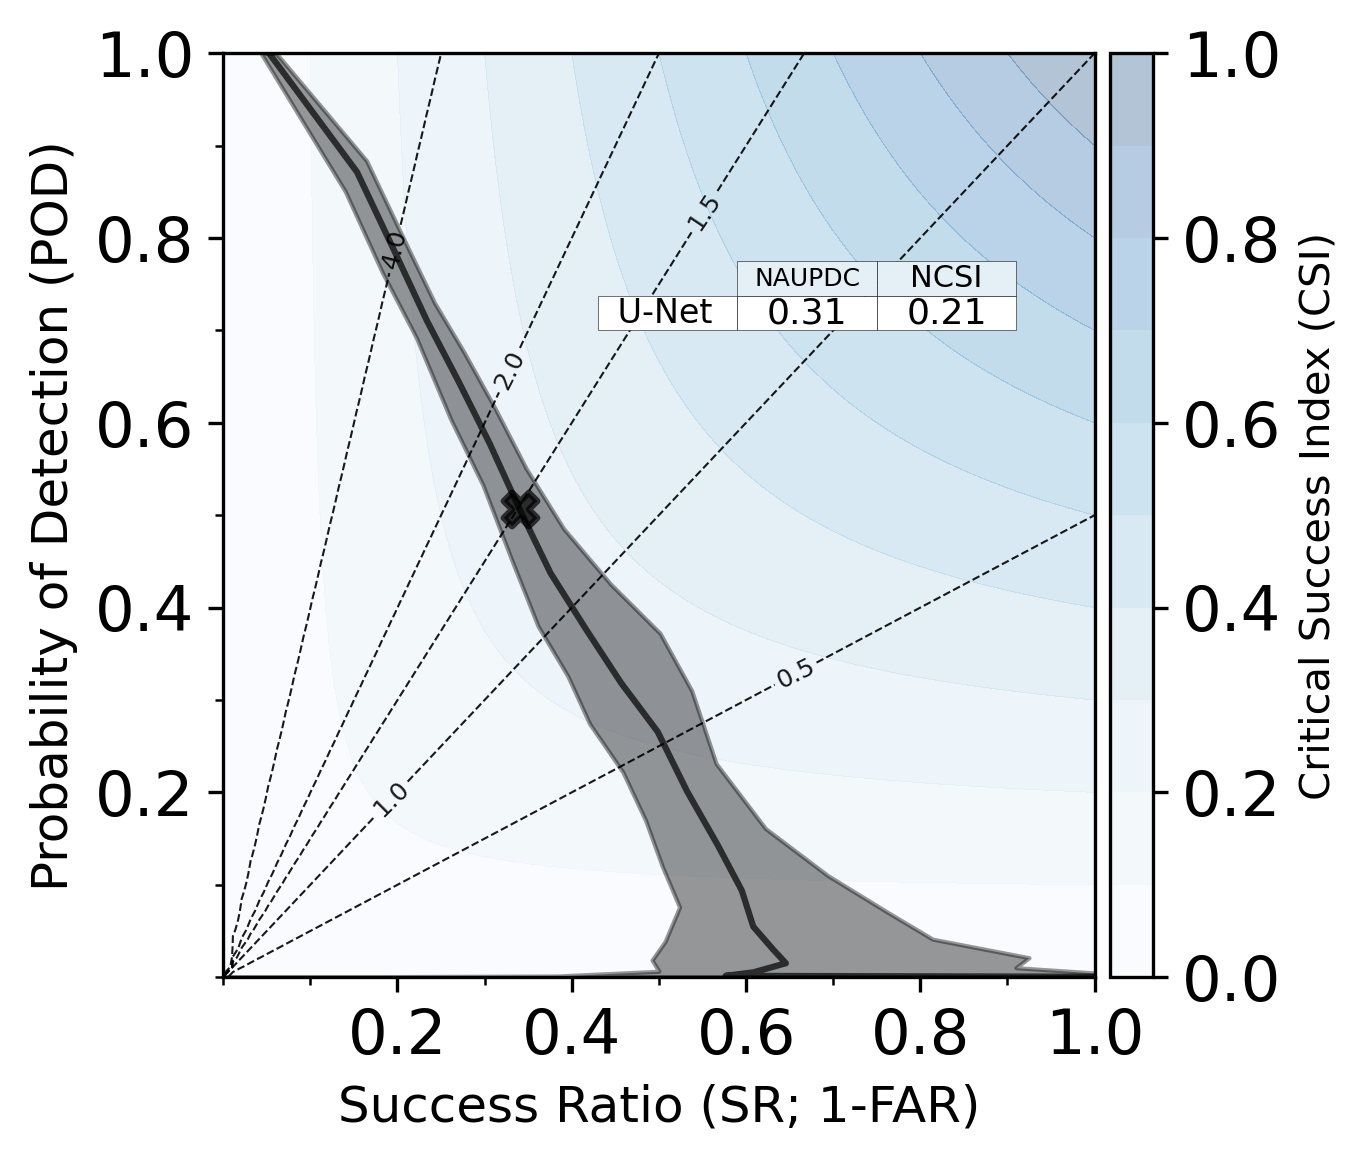

In [39]:
name = 'U-Net'
_xx={}
_yy={}
_scores={}
scores={'U-Net':{}}
xx, yy, score = sklearn_curve_bootstrap(y_test.flatten(), results['predict_test'].flatten(), metric='performance', 
                                         n_boot=15, groups=test_groups, 
                            random_seed=42)
_scores[name]=score
for metric in score:
    scores['U-Net'][metric]=np.nanmean(score[metric])
_xx[name]=xx
_yy[name]=yy
vd = VerificationDiagram()

ax = vd.plot('performance', _xx, _yy, scores=_scores,  add_dots=False, 
             add_max_marker=True, table_fontsize=8,  table_alpha=1, line_colors=['k'],
            plot_kwargs={'line_colors':'k'},
             #table_bbox=[0.75, 0.65, 0.25, 0.4]
            )
plt.show()

# Reliability Diagram

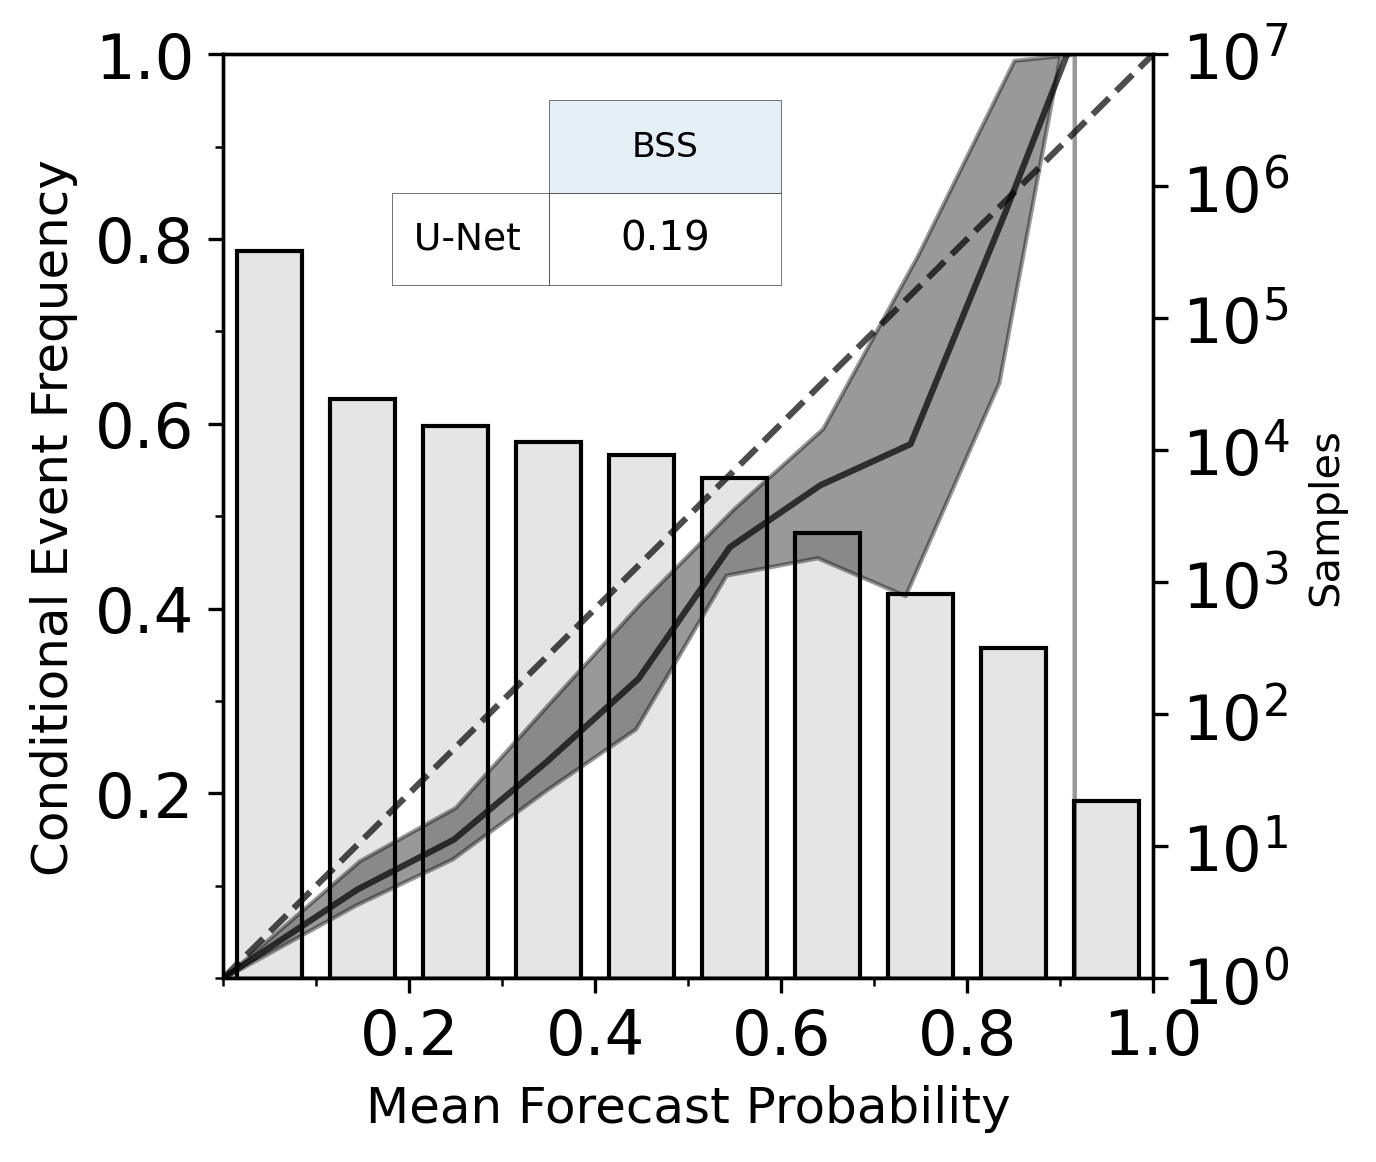

In [53]:
_xx={}
_yy={}
_scores={}
scores={'U-Net':{}}
xx, yy, score = sklearn_curve_bootstrap(y_val.flatten(), results['predict_val'].flatten(), metric='reliability', 
                                         n_boot=20, groups=val_groups, 
                            random_seed=42)
_scores[name]=score
for metric in score:
    scores['U-Net'][metric]=np.nanmean(score[metric])
_xx[name]=xx
_yy[name]=yy

vd = VerificationDiagram(y_pred=results['predict_val'].flatten())
ax = vd.plot('reliability', _xx, _yy, scores=_scores, 
             #table_bbox=[0.46, 0.65, 0.1, 0.4],
             table_bbox=[0.35, 0.75, 0.25, 0.2],
             line_colors=['k'], #0.28
            plot_kwargs={'line_colors':['k']},table_fontsize=9, table_alpha=1, add_dots=False)

plt.show()

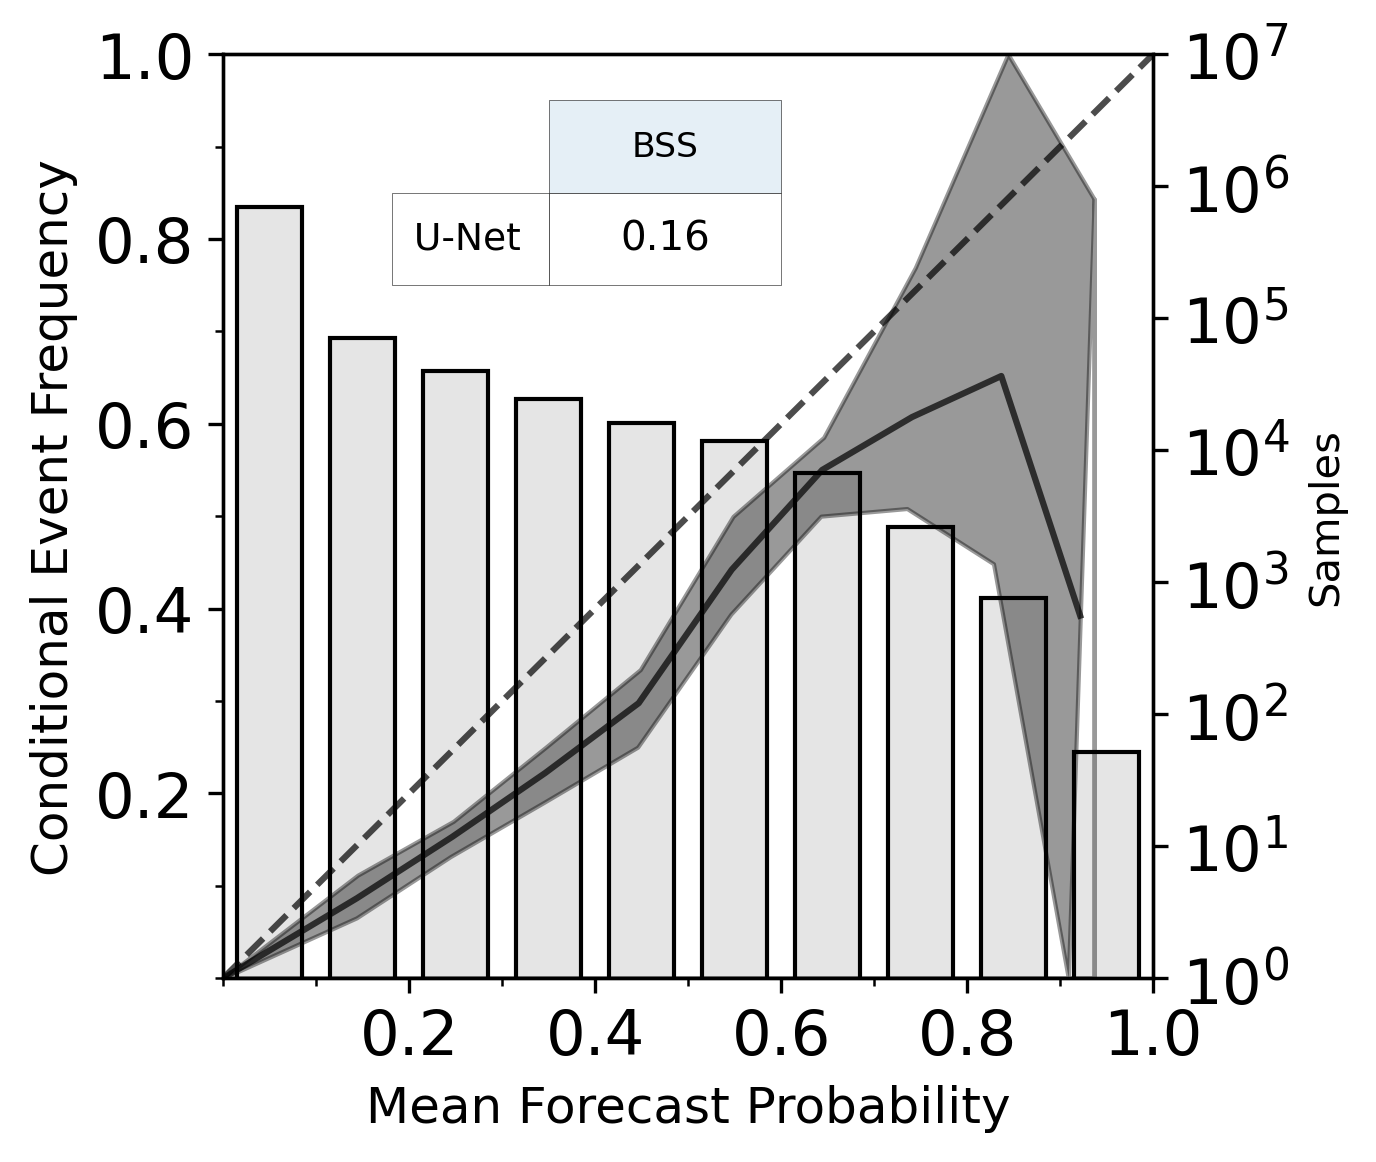

In [55]:
_xx={}
_yy={}
_scores={}
scores={'U-Net':{}}
xx, yy, score = sklearn_curve_bootstrap(y_test.flatten(), results['predict_test'].flatten(), metric='reliability', 
                                         n_boot=20, groups=groups, 
                            random_seed=42)
_scores[name]=score
for metric in score:
    scores['U-Net'][metric]=np.nanmean(score[metric])
_xx[name]=xx
_yy[name]=yy

vd = VerificationDiagram(y_pred=results['predict_test'].flatten())
ax = vd.plot('reliability', _xx, _yy, scores=_scores, 
             #table_bbox=[0.46, 0.65, 0.1, 0.4],
             table_bbox=[0.35, 0.75, 0.25, 0.2],
             line_colors=['k'], #0.28
            plot_kwargs={'line_colors':['k']},table_fontsize=9, table_alpha=1, add_dots=False)

plt.show()

# ROC Curve

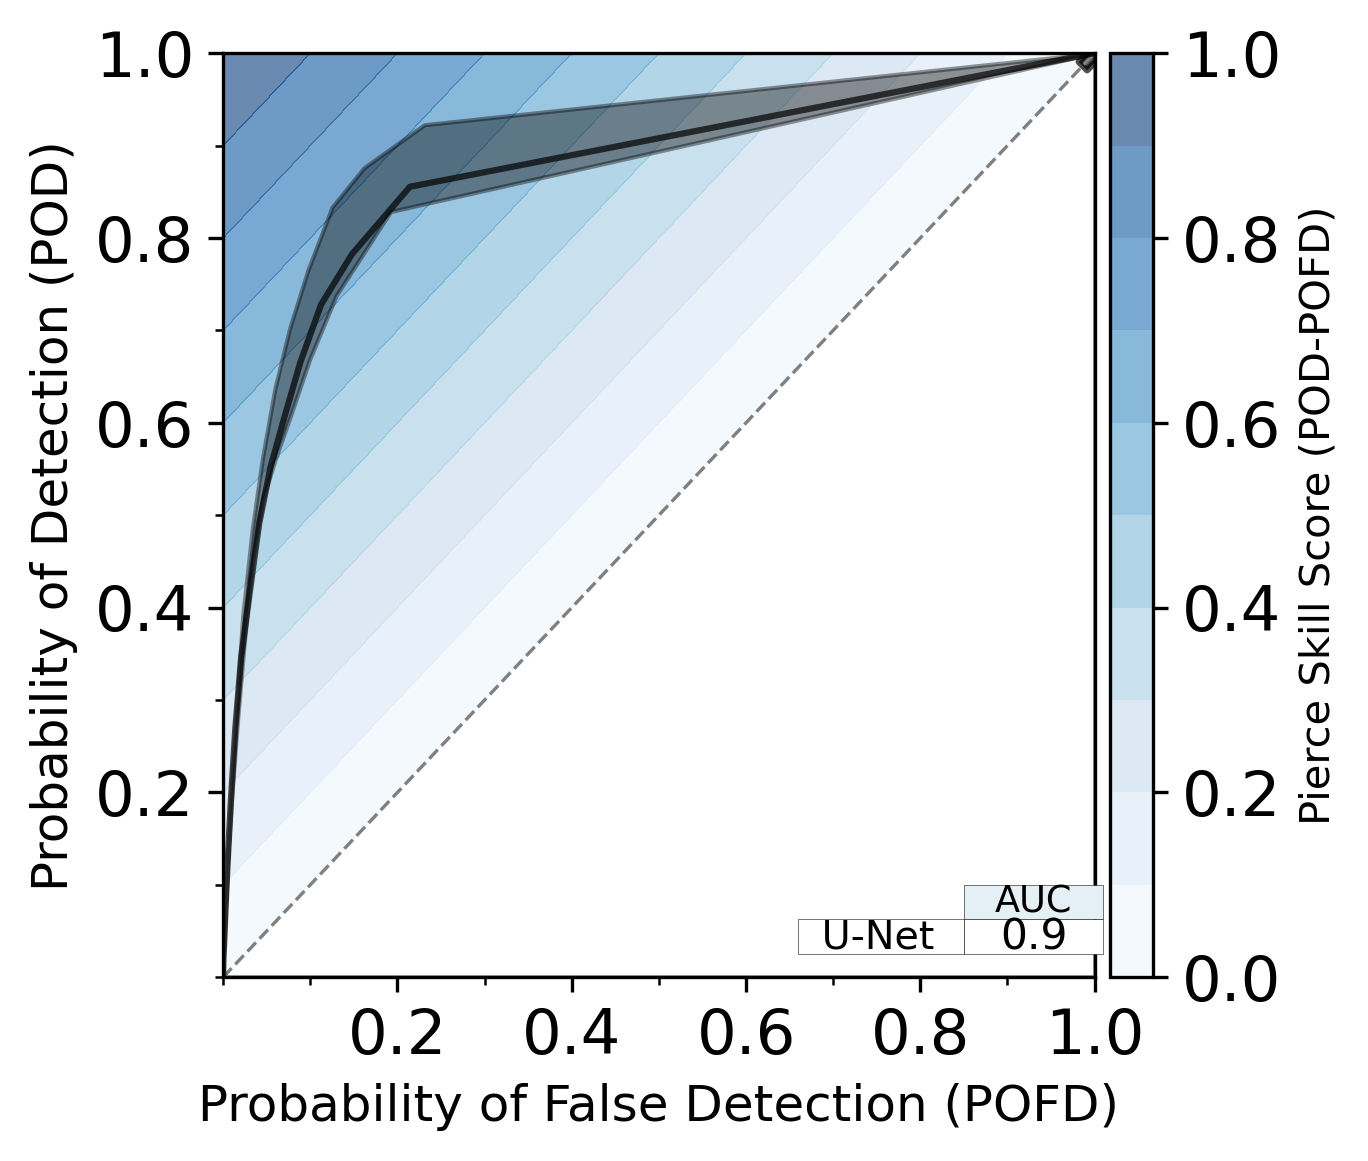

In [56]:
_xx={}
_yy={}
_scores={}
scores={'U-Net':{}}
xx, yy, score = sklearn_curve_bootstrap(y_val.flatten(), results['predict_val'].flatten(), metric='roc', 
                                         n_boot=15, groups=val_groups, 
                            random_seed=42)
_scores[name]=score
for metric in score:
    scores['U-Net'][metric]=np.nanmean(score[metric])
_xx[name]=xx
_yy[name]=yy

vd.plot('roc', _xx, _yy, scores=_scores, add_dots=False, add_max_marker=True, plot_kwargs={'line_colors':['k']},table_fontsize=9.5, table_alpha=1 )

plt.show()

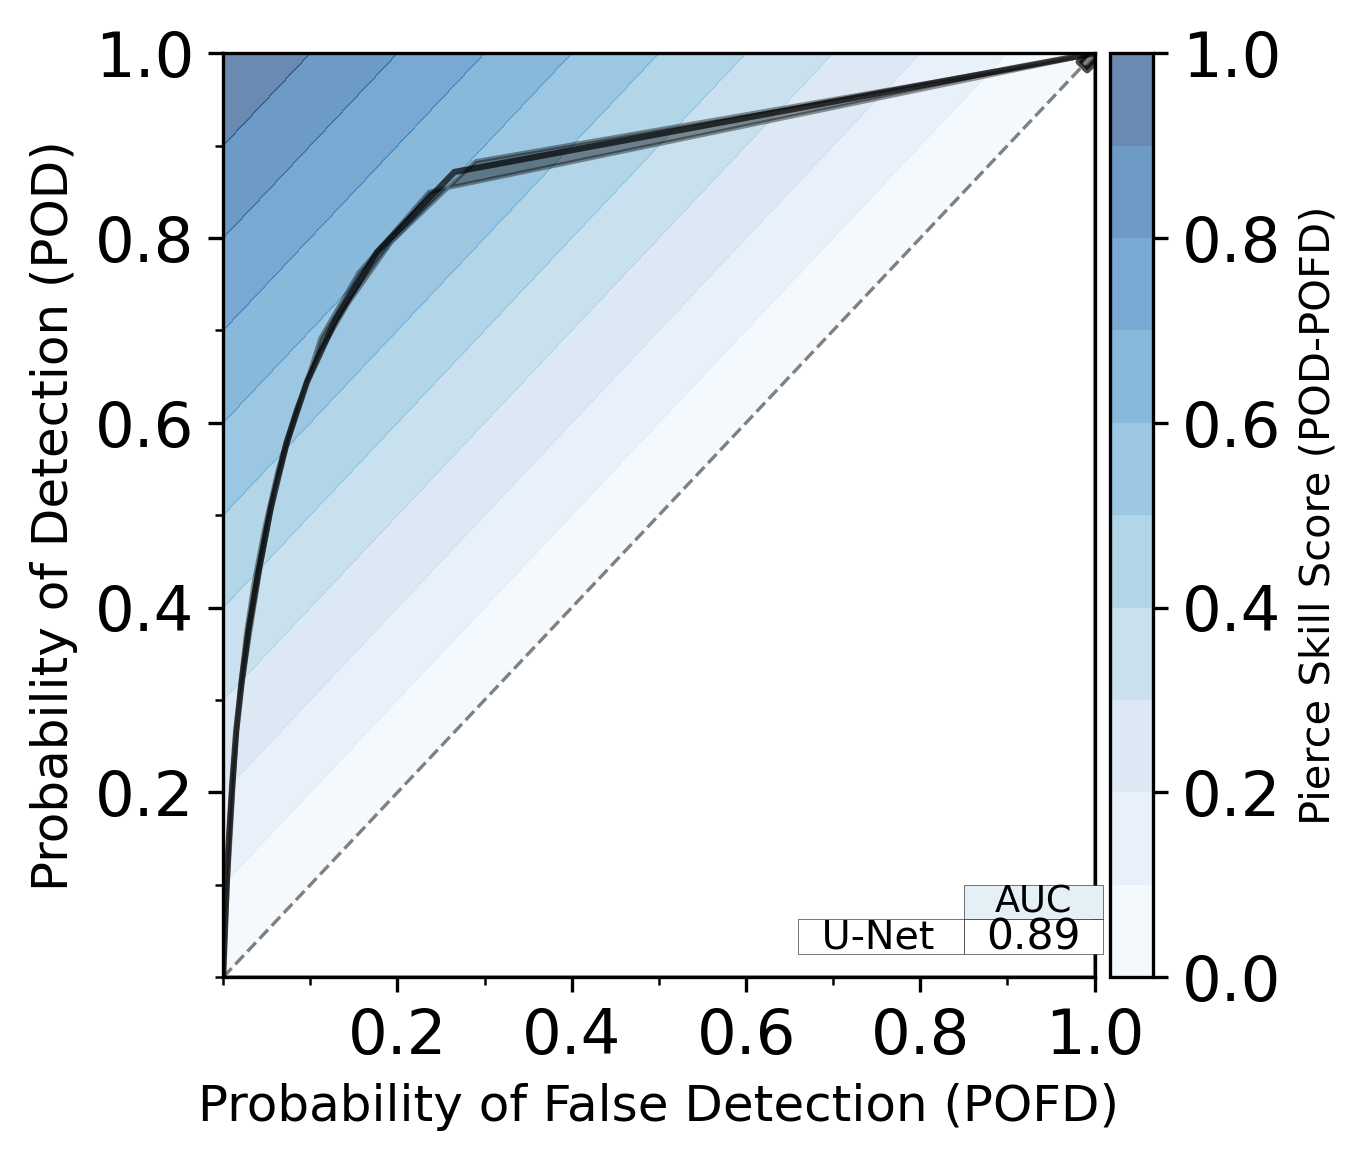

In [57]:
_xx={}
_yy={}
_scores={}
scores={'U-Net':{}}
xx, yy, score = sklearn_curve_bootstrap(y_test.flatten(), results['predict_test'].flatten(), metric='roc', 
                                         n_boot=15, groups=test_groups, 
                            random_seed=42)
_scores[name]=score
for metric in score:
    scores['U-Net'][metric]=np.nanmean(score[metric])
_xx[name]=xx
_yy[name]=yy

vd.plot('roc', _xx, _yy, scores=_scores, add_dots=False, add_max_marker=True, plot_kwargs={'line_colors':['k']},table_fontsize=9.5, table_alpha=1 )

plt.show()